#### Load Dependency

In [1]:
from clearml import Dataset, TaskTypes, Task, Logger
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, \
                            ConfusionMatrixDisplay, precision_recall_fscore_support, PrecisionRecallDisplay
import numpy as np
import matplotlib.pyplot as plt
import joblib
from imblearn.over_sampling import SMOTE, SMOTEN, SMOTENC
plt.rcParams['figure.figsize'] = [20, 15]

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [3]:
dumy_encoded = pd.read_csv('preprocessed_cat_encoded.csv')
dumy_encoded.shape

(2845, 229)

In [4]:
dat_cols = [col for col in dumy_encoded.columns if 'DATE' in col]
dumy_encoded.drop(columns=dat_cols, inplace=True)
dumy_encoded.reset_index(inplace=True, drop=True)
dumy_encoded.shape

(2845, 225)

In [5]:
print(dumy_encoded.REASON_CODE.value_counts())

positive_rows = dumy_encoded[dumy_encoded['REASON_CODE'] != 1.0]
negative_rows = dumy_encoded[dumy_encoded['REASON_CODE'] ==1.0].sample(n=200, random_state=42)

selected_rows = pd.concat([positive_rows, negative_rows])
dumy_encoded = selected_rows
print(dumy_encoded.shape)



X = dumy_encoded.drop(columns='REASON_CODE')
y = dumy_encoded['REASON_CODE']

1     2725
18      30
19      30
10      30
9       30
Name: REASON_CODE, dtype: int64
(320, 225)


#### Split Data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((256, 224), (64, 224), (256,), (64,))

In [7]:
X_train.head().to_csv('X_train.csv', index=False)

In [8]:
'DIFF_PROC_DT_COV_ED_DT' in dumy_encoded.columns

False

In [9]:
#norm_features = ['Age', 'TOTAL_CHARGES', 'SERVICE_UNIT_QUANTITY']
norm_features = ['Age', 'TOTAL_CHARGES', 'SERVICE_UNIT_QUANTITY', 'PROC_COVER_START_DIFF','PROC_COVER_END_DIFF']
scaler = MinMaxScaler()
scaler.fit(X_train[norm_features])


scaled = scaler.transform(X_train[norm_features])
X_train['Age'] =  scaled[:,0]
X_train['TOTAL_CHARGES'] = scaled[:,1]
X_train['SERVICE_UNIT_QUANTITY'] = scaled[:,2]
X_train['PROC_COVER_START_DIFF'] =  scaled[:,3]
X_train['PROC_COVER_END_DIFF'] = scaled[:,4]
X_train.shape


scaled = scaler.transform(X_test[norm_features])

X_test['Age'] =  scaled[:,0]
X_test['TOTAL_CHARGES'] =  scaled[:,1]
X_test['SERVICE_UNIT_QUANTITY'] = scaled[:,2]
X_test['PROC_COVER_START_DIFF'] =  scaled[:,3]
X_test['PROC_COVER_END_DIFF'] = scaled[:,4]

X_test.shape

(64, 224)

In [10]:
joblib.dump(scaler,'./models/mnmx_scaler.joblib')

['./models/mnmx_scaler.joblib']

#### Prepare Data

#### Label Encoding

In [11]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [12]:
joblib.dump(label_encoder,'./models/label_encoder.joblib')

['./models/label_encoder.joblib']

In [13]:
label_encoder.inverse_transform([4])

array([19])

In [14]:
np.unique(y_train)

array([0, 1, 2, 3, 4])

In [15]:
""" #norm_features = ['Age', 'TOTAL_CHARGES', 'SERVICE_UNIT_QUANTITY']
norm_features = ['Age', 'TOTAL_CHARGES', 'SERVICE_UNIT_QUANTITY', 'PROC_COVER_START_DIFF','PROC_COVER_END_DIFF']
scaler = MinMaxScaler()
scaler.fit(X_train[norm_features])


scaled = scaler.transform(X_train[norm_features])
X_train['Age'] =  scaled[:,0]
X_train['TOTAL_CHARGES'] = scaled[:,1]
X_train['SERVICE_UNIT_QUANTITY'] = scaled[:,2]
X_train['PROC_COVER_START_DIFF'] =  scaled[:,3]
X_train['DIFF_PROC_DT_COV_ED_DT'] = scaled[:,4]
X_train.shape


scaled = scaler.transform(X_test[norm_features])

X_test['Age'] =  scaled[:,0]
X_test['TOTAL_CHARGES'] =  scaled[:,1]
X_test['SERVICE_UNIT_QUANTITY'] = scaled[:,2]
X_test['PROC_COVER_START_DIFF'] =  scaled[:,3]
X_test['PROC_COVER_END_DIFF'] = scaled[:,4]

X_test.shape """

" #norm_features = ['Age', 'TOTAL_CHARGES', 'SERVICE_UNIT_QUANTITY']\nnorm_features = ['Age', 'TOTAL_CHARGES', 'SERVICE_UNIT_QUANTITY', 'PROC_COVER_START_DIFF','PROC_COVER_END_DIFF']\nscaler = MinMaxScaler()\nscaler.fit(X_train[norm_features])\n\n\nscaled = scaler.transform(X_train[norm_features])\nX_train['Age'] =  scaled[:,0]\nX_train['TOTAL_CHARGES'] = scaled[:,1]\nX_train['SERVICE_UNIT_QUANTITY'] = scaled[:,2]\nX_train['PROC_COVER_START_DIFF'] =  scaled[:,3]\nX_train['DIFF_PROC_DT_COV_ED_DT'] = scaled[:,4]\nX_train.shape\n\n\nscaled = scaler.transform(X_test[norm_features])\n\nX_test['Age'] =  scaled[:,0]\nX_test['TOTAL_CHARGES'] =  scaled[:,1]\nX_test['SERVICE_UNIT_QUANTITY'] = scaled[:,2]\nX_test['PROC_COVER_START_DIFF'] =  scaled[:,3]\nX_test['PROC_COVER_END_DIFF'] = scaled[:,4]\n\nX_test.shape "

### utilities

In [16]:
all_classes= np.unique(y_train).tolist()
color_names = ['red','green','blue','black','darkorange']
disP_labels  = [str(int(i)) for i in sorted(y.unique().tolist())]

In [17]:
def plot_roc(model,X_test,y_test, all_classes):
  # Predict the probabilities for the test data
  y_score = model.predict_proba(X_test)

  # Binarize the labels (convert to one-hot encoding)
  y_test_bin = label_binarize(y_test, classes=all_classes)
  n_classes = y_test_bin.shape[1]

  # Calculate the ROC curve and AUC score for each class
  fpr = {}
  tpr = {}
  roc_auc = {}

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot the ROC curves for each class
  plt.figure(figsize=(10,10))
  colors = color_names # cycle(['blue','red','green','yellow','pink','orange','magenta','black'])

  for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
    ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic (ROC) curve')
  plt.legend(loc="lower right")
  plt.show()

In [18]:
def plot_cm(y_test,pred_test,disP_labels=None, my_cmap='Blues'):
    # Compute confusion matrix
    cm = confusion_matrix(y_test,pred_test)

    # Display confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disP_labels)
    disp.plot(cmap=my_cmap)

    # Set plot properties
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### Modeling

#### Logistic Regression

In [19]:
lr_model = LogisticRegression(max_iter=1500, class_weight='balanced', multi_class='multinomial')
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1500,
                   multi_class='multinomial')

In [20]:
test_preds = lr_model.predict(X_test)
train_preds = lr_model.predict(X_train)

print(f'LogisticRegression Test Accuracy: {accuracy_score(y_test, test_preds) * 100:.2f}')
print(f'LogisticRegression Train Accuracy: {accuracy_score(y_train, train_preds) * 100:.2f}')

LogisticRegression Test Accuracy: 98.44
LogisticRegression Train Accuracy: 100.00


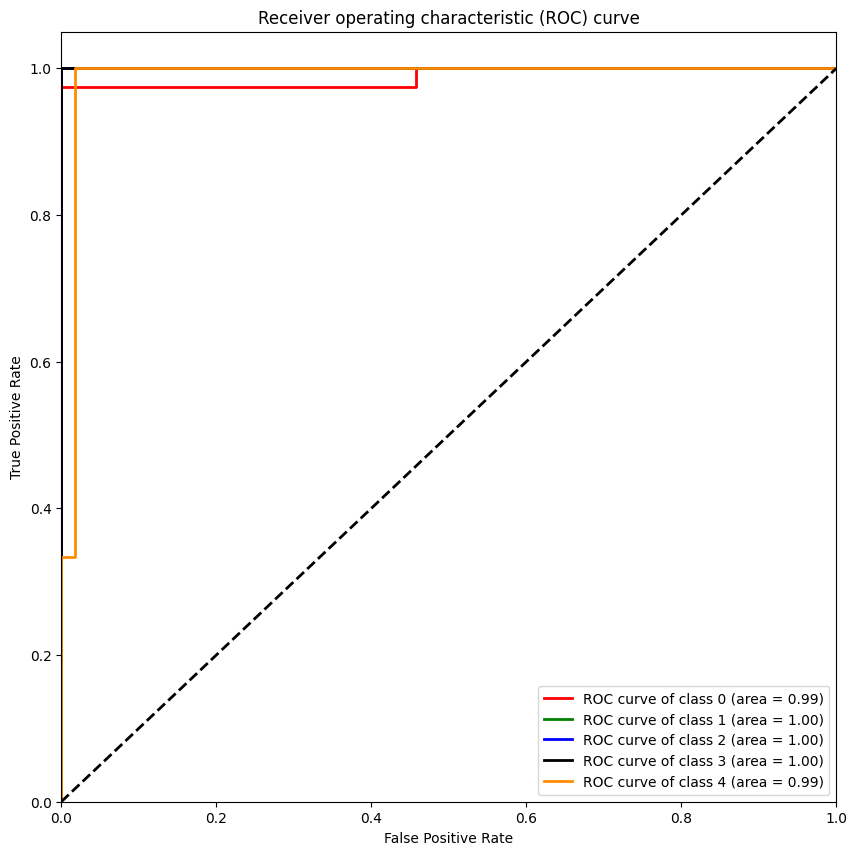

In [21]:
plot_roc(lr_model, X_test, y_test, all_classes=all_classes)

#### Decision Tree

In [22]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [23]:
pred_test= dt_model.predict(X_test)
pred_train= dt_model.predict(X_train)

print(f'DecisionTreeClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'DecisionTreeClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

DecisionTreeClassifier Test Accuracy: 100.00
DecisionTreeClassifier Train Accuracy: 100.00


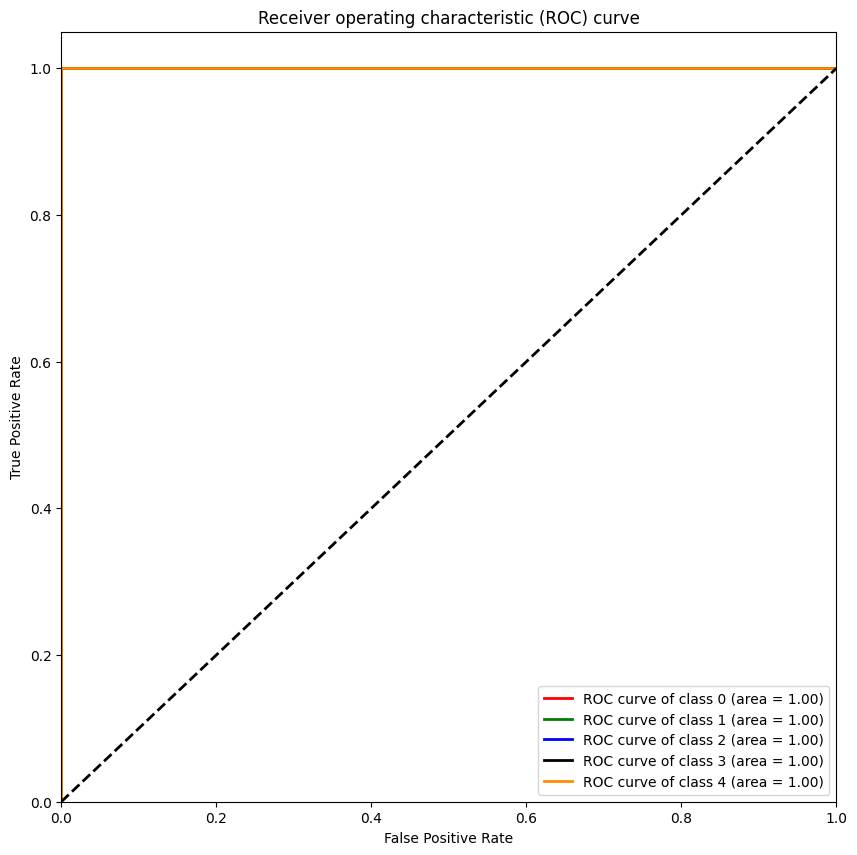

In [24]:
plot_roc(dt_model, X_test, y_test, all_classes=all_classes)

In [25]:
dt_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

#### Random forest Classifier

In [26]:
rf_model = RandomForestClassifier(random_state = 24, n_jobs = -1, class_weight='balanced',n_estimators=1000)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1,
                       random_state=24)

In [27]:
pred_train = rf_model.predict(X_train)
pred_test = rf_model.predict(X_test)

print(f'RandomForestClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'RandomForestClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

RandomForestClassifier Test Accuracy: 96.88
RandomForestClassifier Train Accuracy: 100.00


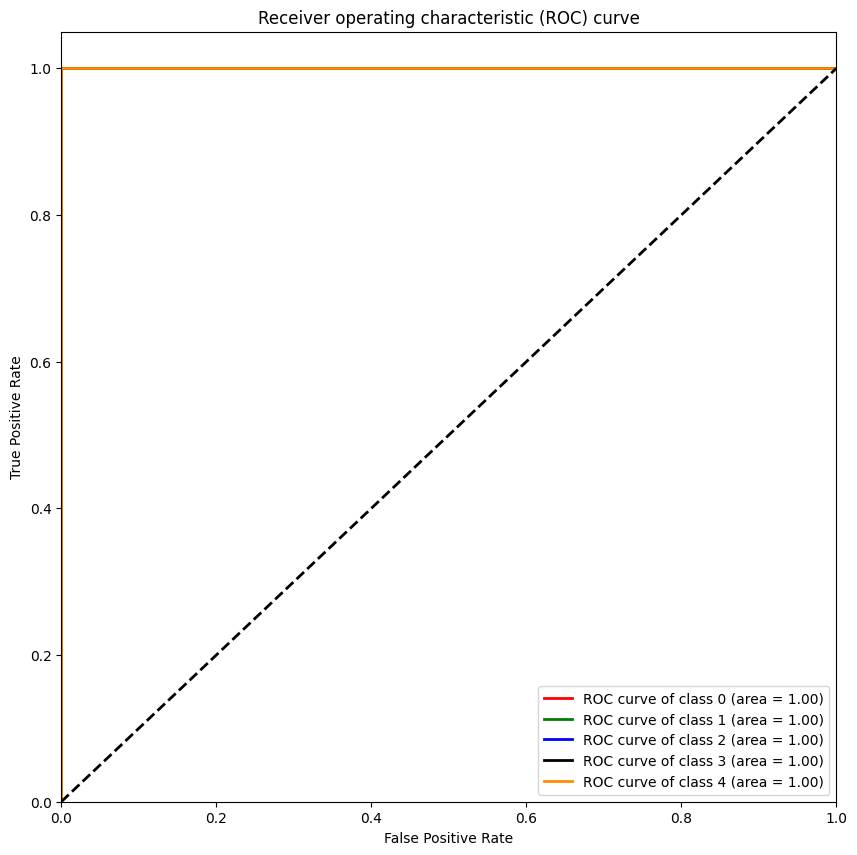

In [28]:
plot_roc(rf_model, X_test, y_test, all_classes=all_classes)

In [29]:
rf_model = RandomForestClassifier(random_state = 24, n_jobs = -1, class_weight='balanced',n_estimators=2000)
rf_model.fit(X_train, y_train)

pred_train = rf_model.predict(X_train)
pred_test = rf_model.predict(X_test)

print(f'RandomForestClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'RandomForestClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')
print(rf_model.get_params())

RandomForestClassifier Test Accuracy: 98.44
RandomForestClassifier Train Accuracy: 100.00
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2000, 'n_jobs': -1, 'oob_score': False, 'random_state': 24, 'verbose': 0, 'warm_start': False}


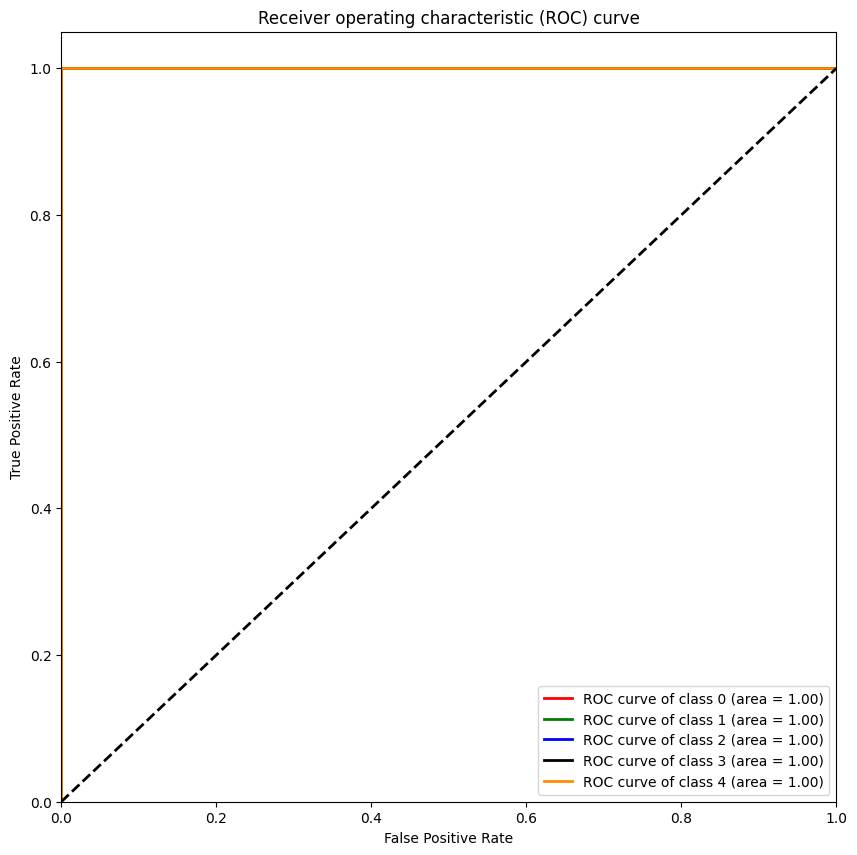

In [30]:
plot_roc(rf_model, X_test, y_test, all_classes=all_classes)

#### GradientBoostingClassifier

In [31]:
model_GB = GradientBoostingClassifier(n_estimators=1000)
model_GB.fit(X_train , y_train)
y_pred = model_GB.predict(X_test)
print(accuracy_score(y_test, y_pred))

pred_test = model_GB.predict(X_test)
pred_train = model_GB.predict(X_train)

print(f'model_GB Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'model_GB Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

1.0
model_GB Test Accuracy: 100.00
model_GB Train Accuracy: 100.00


In [32]:
joblib.dump(model_GB,'./models/GradientBoostingClassifier.joblib')

['./models/GradientBoostingClassifier.joblib']

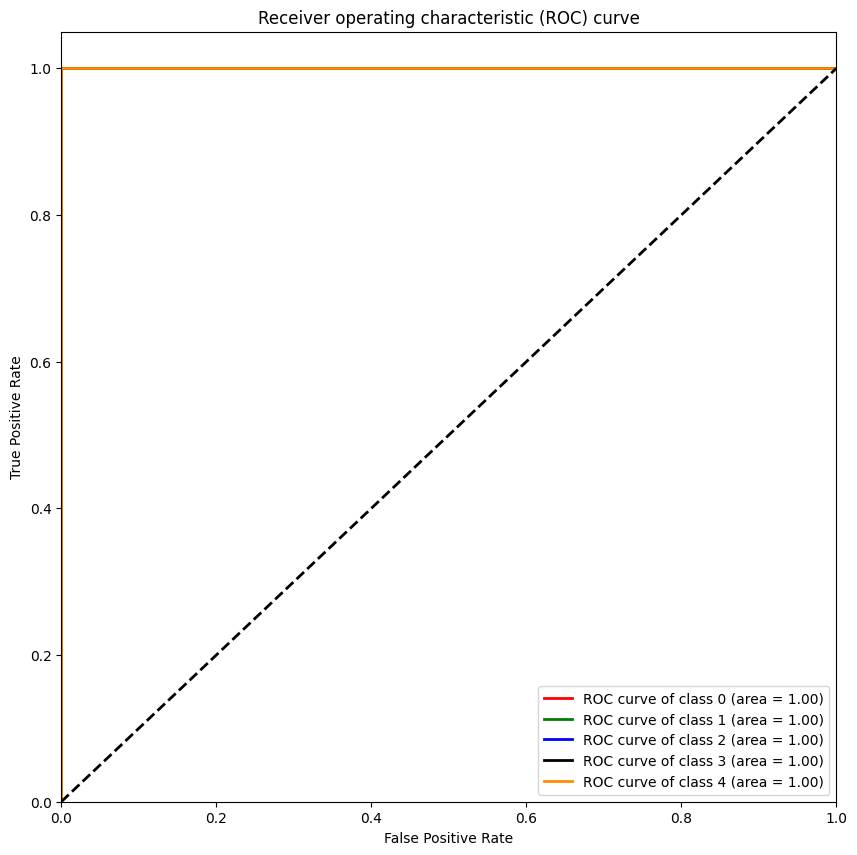

In [33]:
plot_roc(model_GB, X_test, y_test, all_classes=all_classes)

#### AdaBoostClassifier

In [34]:
from sklearn.ensemble import AdaBoostClassifier
model_ad = AdaBoostClassifier(n_estimators=5100)
model_ad.fit(X_train , y_train)
y_pred = model_GB.predict(X_test)
#print(classification_report(y_test, y_pred))

pred_test = model_ad.predict(X_test)
pred_train = model_ad.predict(X_train)

print(f'model_ad Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'model_ad Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

model_ad Test Accuracy: 100.00
model_ad Train Accuracy: 100.00


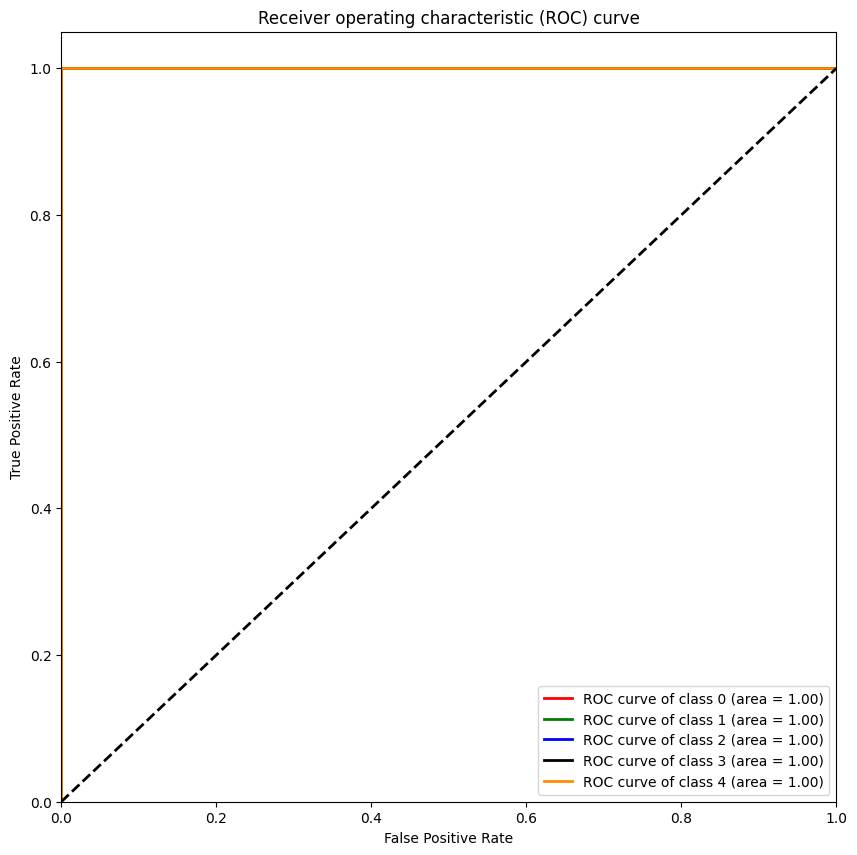

In [35]:
plot_roc(model_ad, X_test, y_test, all_classes=all_classes)

#### -----------------

In [36]:
models = {
    'LogisticRegression':LogisticRegression(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'RandomForestClassifier':RandomForestClassifier()
}

LogisticRegression
LogisticRegression Test Accuracy: 90.62
LogisticRegression Train Accuracy: 100.00


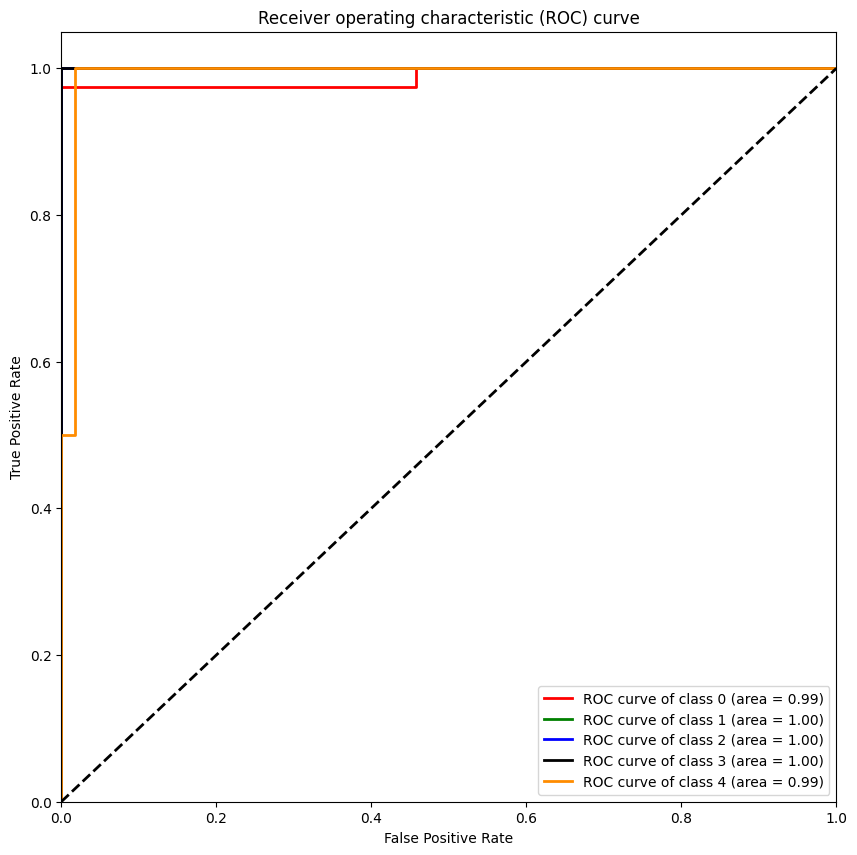

DecisionTreeClassifier
DecisionTreeClassifier Test Accuracy: 100.00
DecisionTreeClassifier Train Accuracy: 100.00


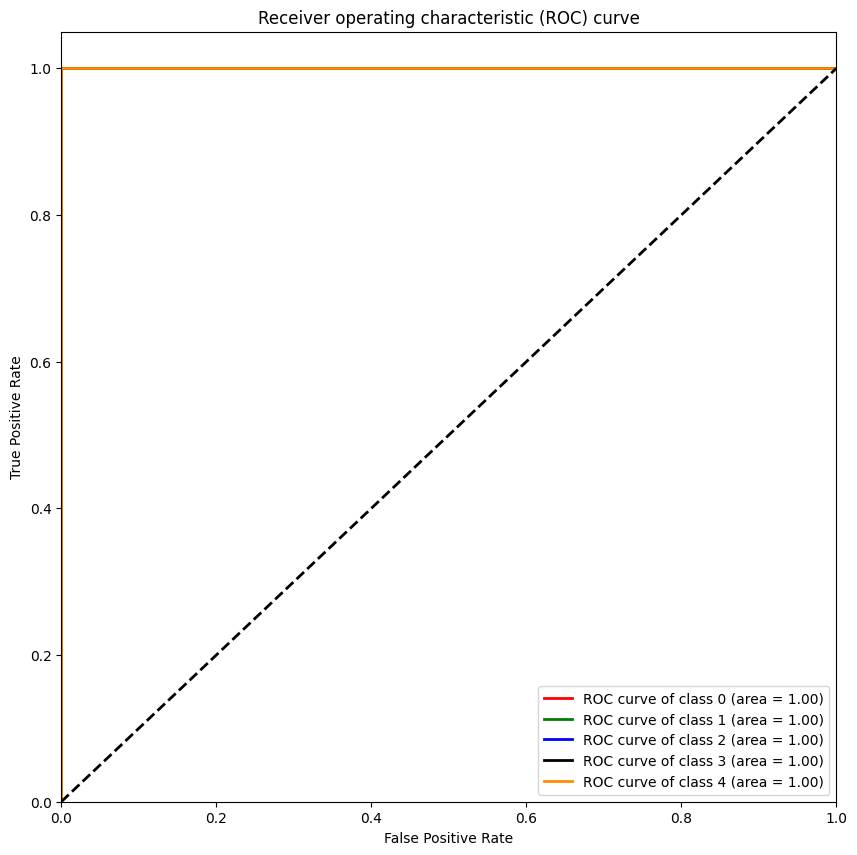

RandomForestClassifier
RandomForestClassifier Test Accuracy: 98.44
RandomForestClassifier Train Accuracy: 100.00


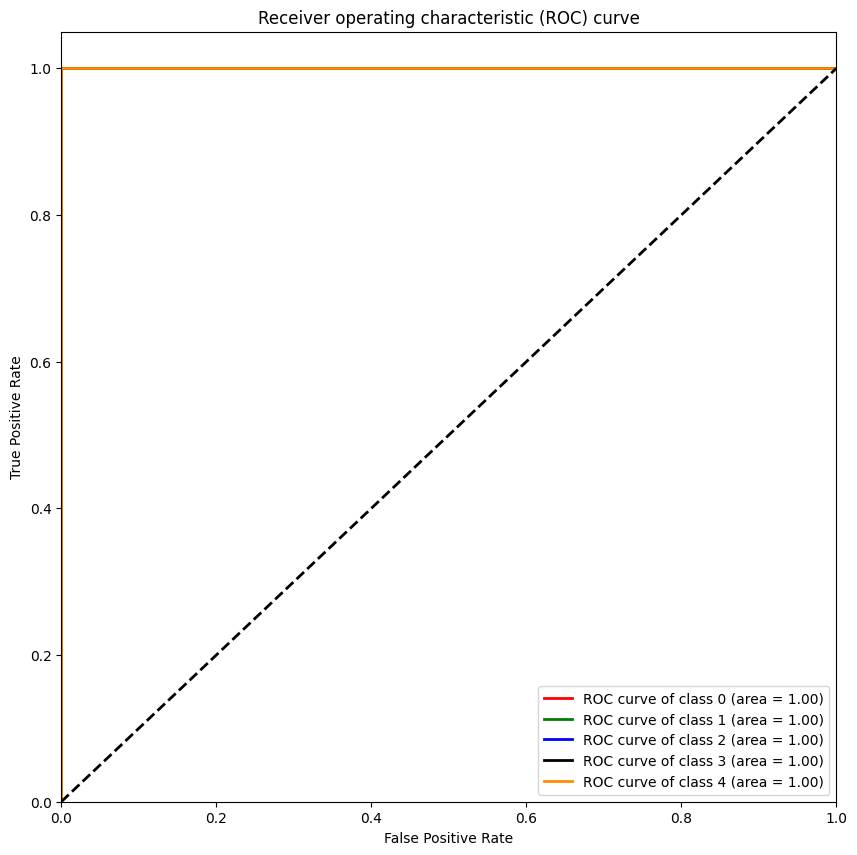

In [37]:
for name,model in models.items():
    print(name)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)

    print(f'{name} Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
    print(f'{name} Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')
    plot_roc(model, X_test, y_test, all_classes=all_classes)

#### Hyperparameter tuning

In [38]:
parame = {
'loss':['log_loss', 'deviance', 'exponential'],
'learning_rate': 0.1,
'n_estimators': 1000,
'subsample': 1,
'criterion':['friedman_mse', 'squared_error'],
'min_samples_split': 1,
'min_samples_leaf':min_samples_leaf,
'max_depth': max_depth,
'init': rf_model,
'random_state': 42,
'max_features':['auto', 'sqrt', 'log2'],
'max_leaf_nodes': 10,
}

NameError: name 'min_samples_leaf' is not defined

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [500,1000.2000]#[int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
# Number of features to consider at every split10
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth =[10, 50, 110]# [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
pred_train = rf_model.predict(X_train)
pred_test = rf_model.predict(X_test)

print(f'RandomForestClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'RandomForestClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

""" import ppscore as pps
dumy_encoded['REASON_CODE'] = dumy_encoded['REASON_CODE'].astype('object')
print(type(pps.predictors(dumy_encoded, "REASON_CODE")))
pps.predictors(dumy_encoded, "REASON_CODE").to_csv('pps.csv',index=False)
 """

#### RepeatedStratifiedKFold

In [ ]:
# fit xgboost on an imbalanced classification dataset
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

label_enc = LabelEncoder()
y_label_enc = label_enc.fit_transform(y)
# define model
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y_label_enc, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

In [ ]:
sum(y.value_counts().tolist()[1:])

In [ ]:
y.value_counts().tolist()[0]

In [ ]:
3687/(3687+1913)